## 1. 最大熵强化学习
- [Soft Actor-Critic:Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor](https://arxiv.org/pdf/1801.01290)
  - 离线策略算法
  - SAC：基于Soft Q-learning改进而来，使用显示的actor函数


- [Soft Q-learning](https://arxiv.org/pdf/1702.08165)

  - 不学习显示的策略函数，而是使用一个Q函数的玻尔兹曼分布
  - learning expressive energy-based policies for continuous states and actions
  - 增强探索能力

对于一个随机变量X,它的概率密度函数为p，它的熵H定义为：
$$
H(X) = \mathbb{E}_{x\sim p}[-\log{p(x)}]
$$
强化学习中可以使用$H(\pi(*|s))$表示策略$\pi$在状态$s$下的探索能力（随机程度）。


#### 标准强化学习
考虑以下infinite-horizon Markov Decision Process$(S, A, p_s, r)$，状态空间$S$和动作空间$A$是连续的:
- 状态转移方程$p_s: S \times S \times A \rightarrow [0, \infty]$
- 奖励函数$r: S\times A\rightarrow [r_{min}, r_{max}]$
- $\rho_{\pi}(s_t)$和$\rho_{\pi}(s_t, a_t)$分别表示state and state-action marginals of the trajectory distribution induced by a policy $\pi(a_t|s_t)$
标准强化学习目标是学习以下最优策略：
$$
\pi_{std}^{*} = \arg\max_{\pi}\sum_{t}\mathbb{E}_{(s_t,a_t)\sim \rho_{\pi}}[r(s_t,a_t)]
$$

#### 最大熵强化学习
SAC 的核心思想是在传统的强化学习目标中引入熵正则化项，形成最大熵强化学习框架。这一框架不仅最大化累计奖励，还最大化策略的熵，鼓励智能体在探索和利用之间找到平衡。
$$
\begin{align}
\pi_{maxEnt}^{*} &= \arg\max_{\pi}\sum_{t}\mathbb{E}_{(s_t,a_t)\sim \rho_{\pi}}[r(s_t,a_t)+\alpha H(\pi(\cdot|s_t))]\\
&= \arg\max_{\pi}\sum_{t}\mathbb{E}_{(s_t)\sim \rho_{\pi}}[\sum r(s_t,a_t)+\alpha H(\pi(\cdot|s_t))]\\
\end{align}
$$
其中$\alpha$是温度系数，控制熵项的重要性；$H(\pi(⋅∣s_t))$表示策略在状态$s_t$下的熵，衡量策略的随机性。


通过最大化每个状态$s_t$的熵从而增加每个状态$s_t$下的策略探索能力。

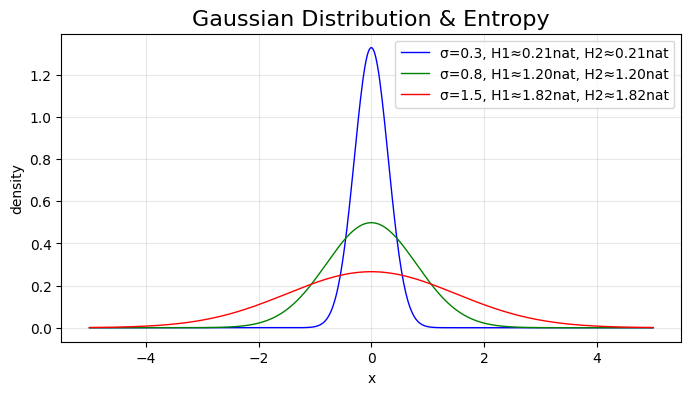

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 理论熵计算函数
def gaussian_entropy_theoretical(sigma):
    """计算一维高斯分布的理论熵（单位：nat）"""
    return 0.5 * np.log(2 * np.pi * np.e * (sigma ** 2))

# 采样熵计算函数
def gaussian_entropy_sampling(mu, sigma, num_samples=100000):
    """通过采样计算高斯分布的熵（单位：nat）"""
    # 从高斯分布中采样
    samples = np.random.normal(mu, sigma, num_samples)
    
    # 计算每个样本的概率密度
    densities = norm.pdf(samples, mu, sigma)    
    densities = np.clip(densities, 1e-10, None)
    
    # 计算熵的蒙特卡洛估计
    entropy = -np.mean(np.log(densities))
    return entropy

sigmas = [0.3, 0.8, 1.5]
colors = ['blue', 'green', 'red']
x = np.linspace(-5, 5, 500)
plt.figure(figsize=(8, 4))

for sigma, color in zip(sigmas, colors):
    y = norm.pdf(x, 0, sigma)  # 均值为0，标准差为sigma
    entropy_theorectical = gaussian_entropy_theoretical(sigma)
    entropy_sample = gaussian_entropy_sampling(mu, sigma)
    plt.plot(x, y, color=color, lw=1, label=f'σ={sigma}, H1≈{entropy_theorectical:.2f}nat, H2≈{entropy_sample:.2f}nat')

plt.title('Gaussian Distribution & Entropy', fontsize=16)
plt.xlabel('x', fontsize=10)
plt.ylabel('density', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.show()

## 2. SAC：soft actro-critic

#### 动作价值函数Q
SAC算法包含两个动作价值函数$Q_1$、$Q_2$和一个策略函数$\pi$：
- 采用两个Q函数缓解Q值估计过高的问题：每次选择$min(Q_1(s,a),Q_2(s,a))$
- 同时采用目标网络$Q_1^{target}$、$Q_2^{target}$

每个Q网络的损失函数如下，而目标网络更新方式跟DDPG算法中目标网络一样：
$$
\begin{align}
L_{\omega} &=\mathbb{E}_{(s_t,a_t,r_t,s_{t+1}\sim R)}[(Q_{\omega}(s_t,a_t)- (r_t+\gamma(\underset{j=1,2}{min}Q_{\omega_j^{target}}(s_{t+1},a_{t+1}))-\alpha\log{\pi(a_{t+s}|s_{t+1})})))^2] \
\end{align}
$$

#### 策略函数$\pi$
SAC的策略目标可以理解为最大化状态价值函数:
$$
\begin{align}
V(s_t) &= \mathbb{E}_{a_t\sim\pi}[\underset{s_t}{\sum}Q(s_t,a_t) + \alpha H(\pi(*|s_t))]\\
&= \color{red}\mathbb{E}_{a_t\sim\pi}[\underset{s_t}{\sum}[Q(s_t,a_t) - \alpha\log(\pi(a_t|s_t))]]
\end{align}
$$

因此策略网络的最小化目标损失函数为
$$
L_{\pi}(\theta)= \mathbb{E}[\alpha\log(\pi_{\theta}(a_t|s_t))-Q_{\omega}(s_t,a_t)]
$$

对于连续动作问题，SAC策略输出高斯分布的均值和方差



## 3. 自适应熵权重系数


## 4. 连续动作变换、采样梯度修正

#### 原始采样方式：不可导
从概率分布中采样是一个随机过程，这个操作本身是不可导的，因此sample操作阻断了梯度传播:
$$
a_t = sample(N(\mu(s_t), \sigma(a_t)))
$$
#### SAC通过重参数化技巧解决采样过程的梯度传播的问题

在连续动作空间中，SAC算法Actor网络输出均值$\mu(s)$和标准差$\sigma(s)$，策略网络输出动作的均值和标准差，通脱以下公式进行采样
$$
a_t = tanh(\mu(s_t) + \epsilon\cdot\sigma(s_t))，其中\epsilon\sim N(0,1)
$$
- 采样行为发生在标准正太分布$\epsilon$上,过这种方式，而$\epsilon$与策略网络的参数无关
- $tanh$函数将动作范围限制到$(-1,1)$
- $a_t$的梯度可以通过$\mu(s_t)$和$\sigma(s_t)$传播到网络上。
  
这样将随机性转移到输入噪声$\epsilon$上，使得梯度可以直接反向传播到策略网络的参数，解决了传统策略梯度方法中动作采样过程不可导导致梯度估计方差较大的问题。